In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import h5py
import PIL
import sys  
import os
import torch

In [2]:
#from data.convert_distance_to_depth import * 
from set_method import my_method, Method


module_path = os.path.abspath(os.path.dirname(os.getcwd()))+"/../" # Only works if cwd correctly gets the model folder.


if module_path not in sys.path:
    sys.path.append(module_path)

from data.convert_distance_to_depth import *
from loaddata import *



    

In [3]:
#test_dataframe = pd.read_csv("../../data/downloads/image_file_test.csv")

# Validation from the cluster:
# Depth,Segmentation,ToneMapped
# ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0006.depth_meters.hdf5,ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0006.semantic.hdf5,ai_001_001/images/scene_cam_00_final_preview/frame.0006.tonemap.jpg
# os.environ["THREED_VISION_ABSOLUTE_DOWNLOAD_PATH"] = "/home/user/ethz/semester4/3dVision/3DVision--Infusing-Monocular-Depth-Semantic/data/downloads/"
os.environ["THREED_VISION_ABSOLUTE_DOWNLOAD_PATH"] = "/home/user/Nextcloud/Documents/ETHZ/semester4/3dVision/3DVision--Infusing-Monocular-Depth-Semantic/data/downloads/"
download_path = os.getenv("THREED_VISION_ABSOLUTE_DOWNLOAD_PATH") or "/home/user/ethz/semester4/3dVision/3DVision--Infusing-Monocular-Depth-Semantic/data/downloads/"
validation_image_path = ["ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0006.depth_meters.hdf5","ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0006.semantic.hdf5","ai_001_001/images/scene_cam_00_final_preview/frame.0006.tonemap.jpg"]
validation_image_path_csv = "../outputs/results/"+ "valid_image.csv"
validation_tensor_path = "../outputs/results/"+ "validation-.05-10-2023-14-59-41-depth.pt"

my_method = Method.NOSEGMENTATIONCUES

mean,std = [0.53277088, 0.49348648, 0.45927282],[0.238986 ,  0.23546355 ,0.24486044] 

In [4]:
def display_tensor_data(tensor, remap=None):
    if remap != None:
        tensor = remap(tensor)
    fig, (ax) = plt.subplots(1)
    pcm = ax.imshow(tensor.permute(1,2,0))
    fig.colorbar(pcm, ax=ax) #ticks=[-1, 0, 1]) 
    plt.show()
    
def display_tensor_data_many(tensors,remap=None):
    nb = len(tensors)
    fig, axes = plt.subplots(1,nb)
    if remap is not None:
        for i in range(nb):
            if remap[i] is not None:
                tensors[i] = remap[i](tensors[i])
                
         
    for i,ax in enumerate(axes) :
        pcm = ax.imshow(tensors[i].permute(1,2,0))
        fig.colorbar(pcm, ax=ax) #ticks=[-1, 0, 1]) 
    plt.show()
    
def display_image_pairs(rgb_image_tensor, segmentation):
    fig, axs = plt.subplots(2)
    axs[0].imshow(rgb_image_tensor.permute(1,2,0))
    axs[1].imshow(segmentation)
    plt.show()
    
def compute_error(ground_truth_depth, depth_output):
    error = torch.abs(ground_truth_depth - depth_output); 
    thr = 0.6;
    error[error < thr] = 0
    return error
        
def display_image_triplets(ground_truth_depth, depth_output):
    
    print("Depth max: ", depth_output.max())
    print("Depth min: ", depth_output.min())
    print("Depth groundtruth max: ", ground_truth_depth.max())
    print("Depth groundtruth min: ", ground_truth_depth.min())
    error = compute_error(ground_truth_depth, depth_output)
        
    print("Error max: ", error.max())
    print("Error min: ", error.min())
    min_scale = min(ground_truth_depth.min(), depth_output.min())
    max_scale = max(ground_truth_depth.max(), depth_output.max())
    if ground_truth_depth.isnan().any():
        temp = ground_truth_depth
        temp[temp.isnan()] = 3; 
        min_scale = min(temp.min(), depth_output.min())
        max_scale = max(temp.max(), depth_output.max())
        print("Min_Scale: ", min_scale)
        print("Max_Scale: ", max_scale)
        
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 16))
    pcm = axs[0].imshow(ground_truth_depth.permute(1,2,0), vmax = max_scale, vmin = min_scale)
    fig.colorbar(pcm, ax=axs[0],fraction=0.046, pad=0.04)
    pcm2 = axs[1].imshow(depth_output.permute(1,2,0), vmax = max_scale, vmin = min_scale)
    fig.colorbar(pcm2, ax=axs[1], fraction=0.046, pad=0.04)
    pcm3 = axs[2].imshow(error.permute(1,2,0))
    fig.colorbar(pcm3, ax=axs[2],fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.show()
    #plt.savefig("plots/")

    
def plot(ground_truth_depth, depth_output, rgb_image, plot_name):
    print("Depth max: ", depth_output.max())
    print("Depth min: ", depth_output.min())
    print("Depth groundtruth max: ", ground_truth_depth.max())
    print("Depth groundtruth min: ", ground_truth_depth.min())
    error = compute_error(ground_truth_depth, depth_output)
        
    print("Error max: ", error.max())
    print("Error min: ", error.min())
    min_scale = min(ground_truth_depth.min(), depth_output.min())
    max_scale = max(ground_truth_depth.max(), depth_output.max())
    if ground_truth_depth.isnan().any():
        temp = ground_truth_depth
        temp[temp.isnan()] = 3; 
        min_scale = min(temp.min(), depth_output.min())
        max_scale = max(temp.max(), depth_output.max())
        print("Min_Scale: ", min_scale)
        print("Max_Scale: ", max_scale)
        
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 16))
    axs[0].imshow(rgb_image.permute(1,2,0))
    axs[0].set_xlabel("Input Image")
    pcm = axs[1].imshow(ground_truth_depth.permute(1,2,0), vmax = max_scale, vmin = min_scale)
    fig.colorbar(pcm, ax=axs[1],fraction=0.046, pad=0.04)
    axs[1].set_xlabel("Ground Truth Depthmap in meters")
    pcm2 = axs[2].imshow(depth_output.permute(1,2,0), vmax = max_scale, vmin = min_scale)
    fig.colorbar(pcm2, ax=axs[2], fraction=0.046, pad=0.04)
    axs[2].set_xlabel("Model Output Depthmap in meters")
    pcm3 = axs[3].imshow(error.permute(1,2,0))
    fig.colorbar(pcm3, ax=axs[3],fraction=0.046, pad=0.04)
    axs[3].set_xlabel("L1 error thresholded at 0.6 m")
    fig.tight_layout()
    plt.show()
    fig.savefig(plot_name, bbox_inches='tight')
    

def normalize(tensor, mean, std):
    """Normalize a tensor image with mean and standard deviation.
    See ``Normalize`` for more details.
    Args:
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        mean (sequence): Sequence of means for R, G, B channels respecitvely.
        std (sequence): Sequence of standard deviations for R, G, B channels
            respecitvely.
    Returns:
        Tensor: Normalized image.
    """

    # TODO: make efficient
    tensor_copy = tensor.clone().detach()
    for t, m, s in zip(tensor_copy, mean, std):
        print(t.min())
        print(t.max())
        t.sub_(m).div_(s)
        print(t.min())
        print(t.max())
        
        
    return tensor_copy

def denormalize(image_input):
    image = image_input.clone().detach()
    for channel in range(0, image.shape[0]):
        image[channel,:,:].mul_(std[channel]).add_(mean[channel])
    return image

In [5]:
depth_outputs = torch.load(download_path+validation_tensor_path)

print(depth_outputs.shape)

torch.Size([4, 1, 1, 114, 152])


In [6]:
test_loader = getTestingData(1, validation_image_path_csv)

My Method in dataloader is:  Method.NOSEGMENTATIONCUES


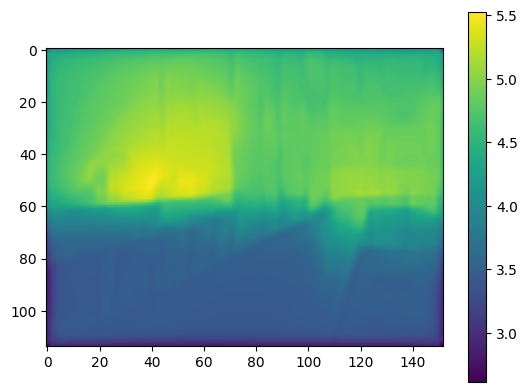

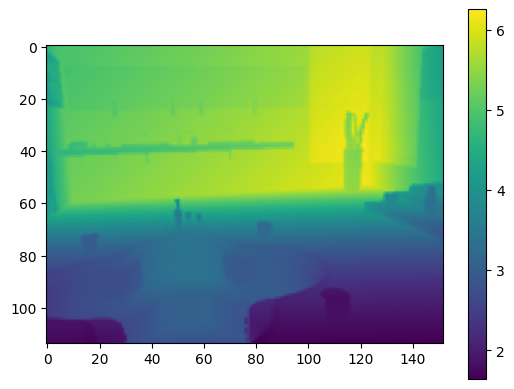

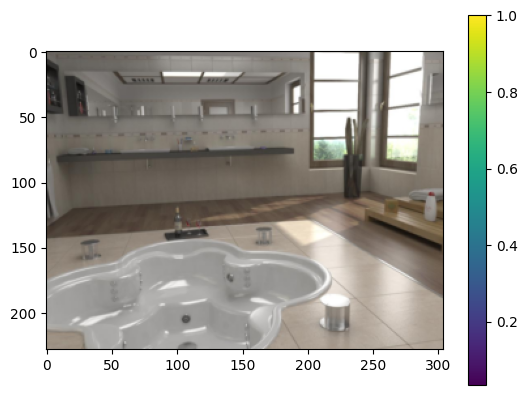

====


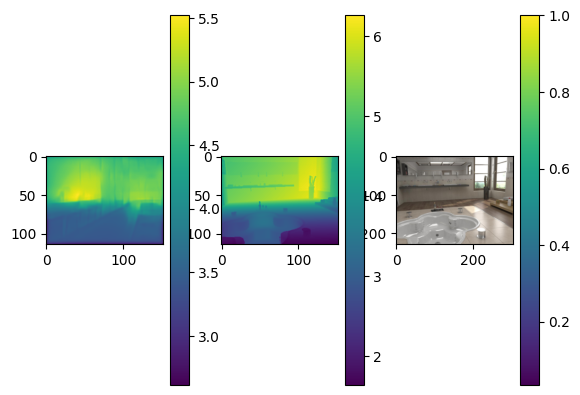

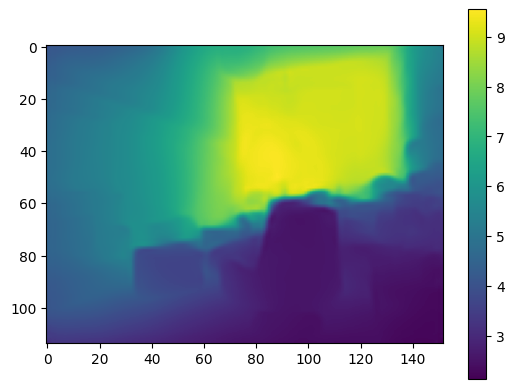

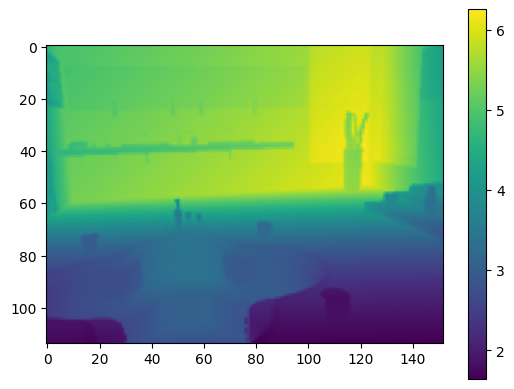

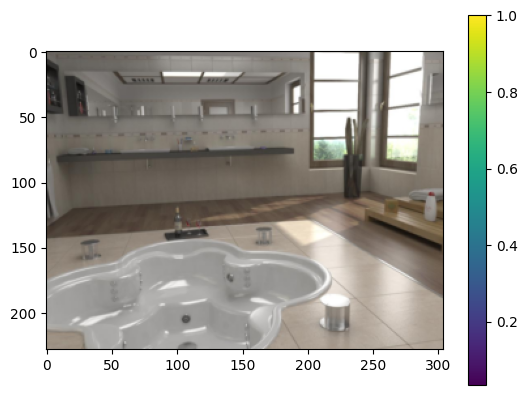

====


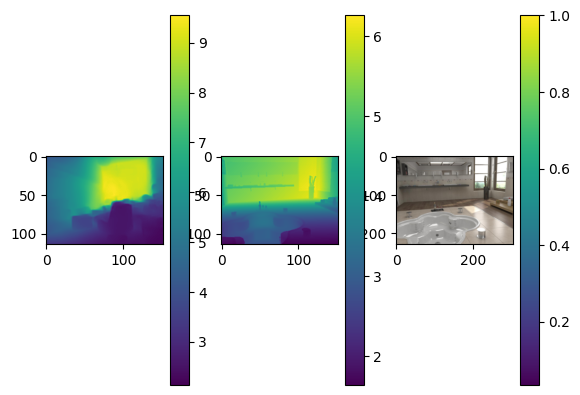

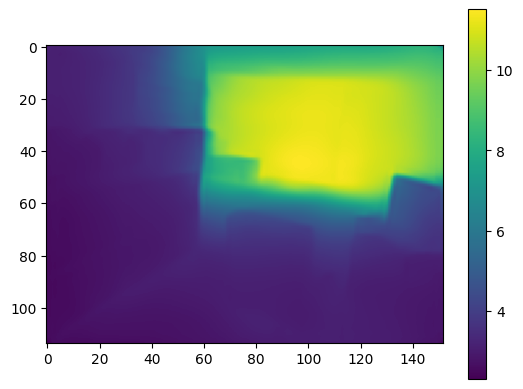

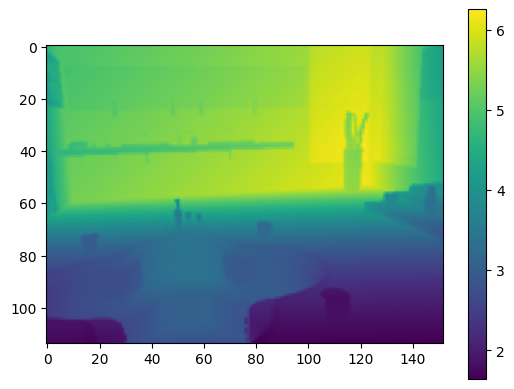

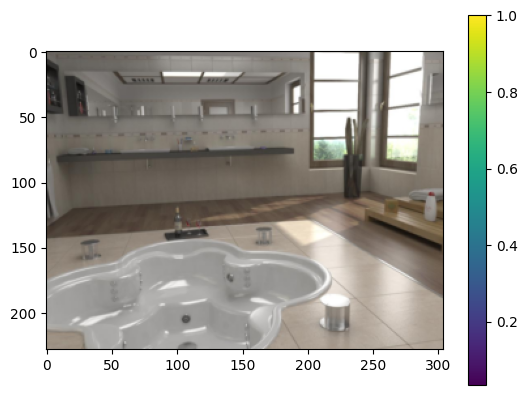

====


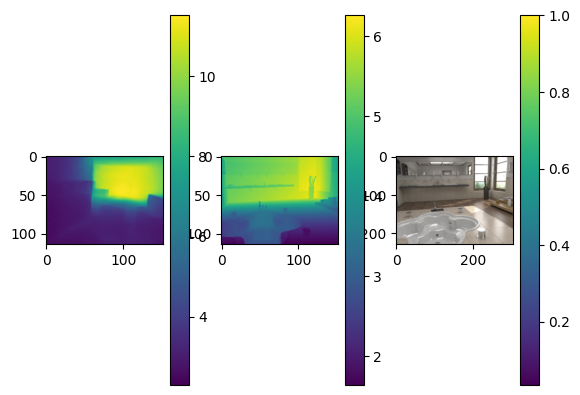

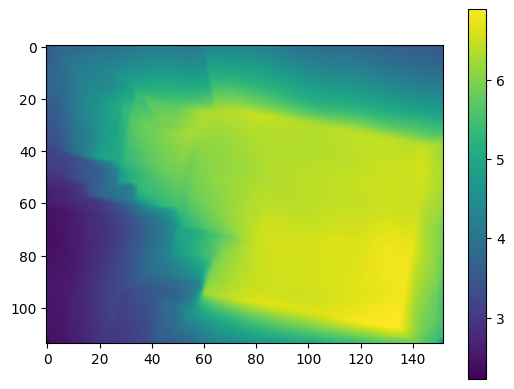

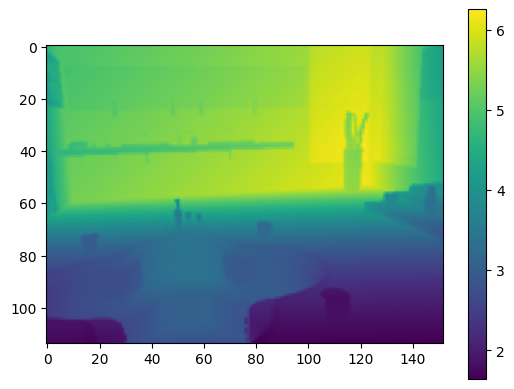

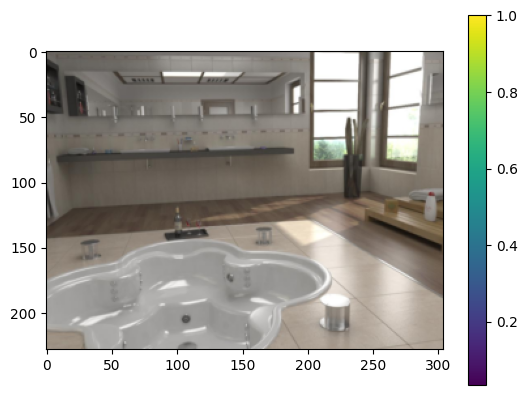

====


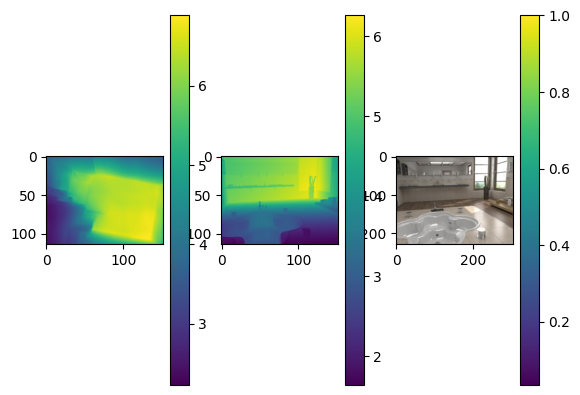

In [7]:
sample_batched = next(iter(test_loader))
for i in range(depth_outputs.shape[0]):
    curr_depth = depth_outputs[i,0,:,:,:].cpu()
    display_tensor_data(curr_depth.detach())
    display_tensor_data(sample_batched["depth"][0,:].detach())
    display_tensor_data(sample_batched["image"][0,:].detach(), denormalize)
    print("====")
    display_tensor_data_many([curr_depth.detach(),sample_batched["depth"][0,:].detach(),sample_batched["image"][0,:].detach()],remap=[None,None,denormalize])

0
Depth max:  tensor(5.5212)
Depth min:  tensor(2.6138)
Depth groundtruth max:  tensor(6.2561)
Depth groundtruth min:  tensor(1.6435)
Error max:  tensor(1.7318)
Error min:  tensor(0.)


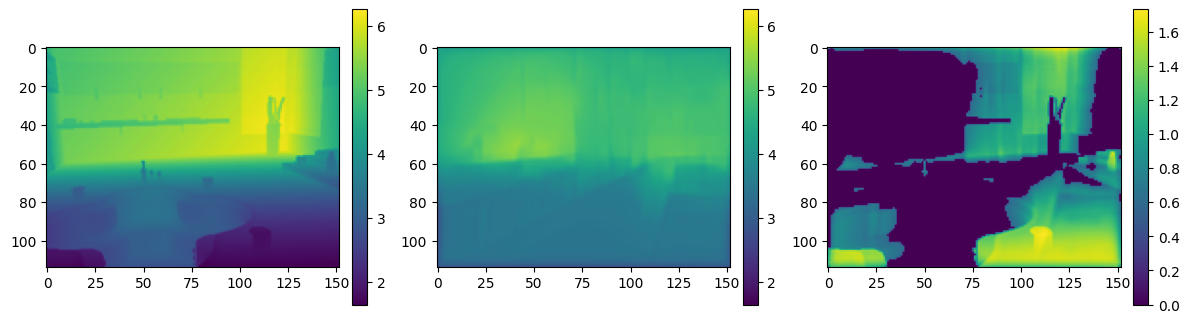

1
Depth max:  tensor(9.5497)
Depth min:  tensor(2.1346)
Depth groundtruth max:  tensor(6.2561)
Depth groundtruth min:  tensor(1.6435)
Error max:  tensor(4.3095)
Error min:  tensor(0.)


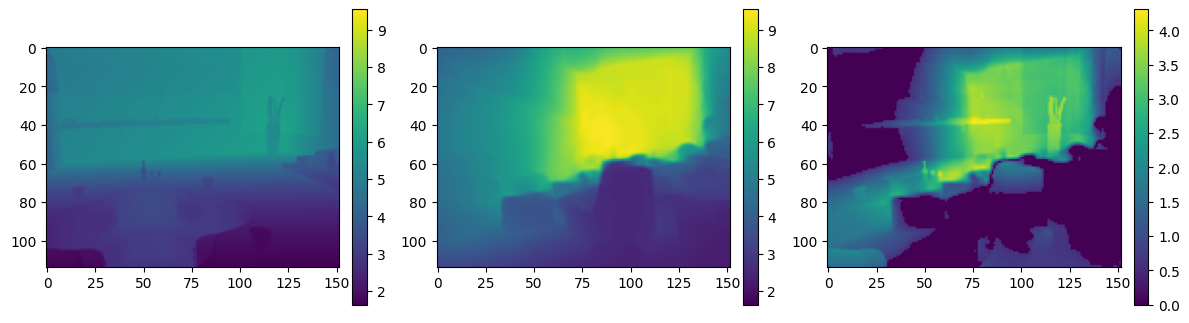

2
Depth max:  tensor(11.5173)
Depth min:  tensor(2.2988)
Depth groundtruth max:  tensor(6.2561)
Depth groundtruth min:  tensor(1.6435)
Error max:  tensor(6.1083)
Error min:  tensor(0.)


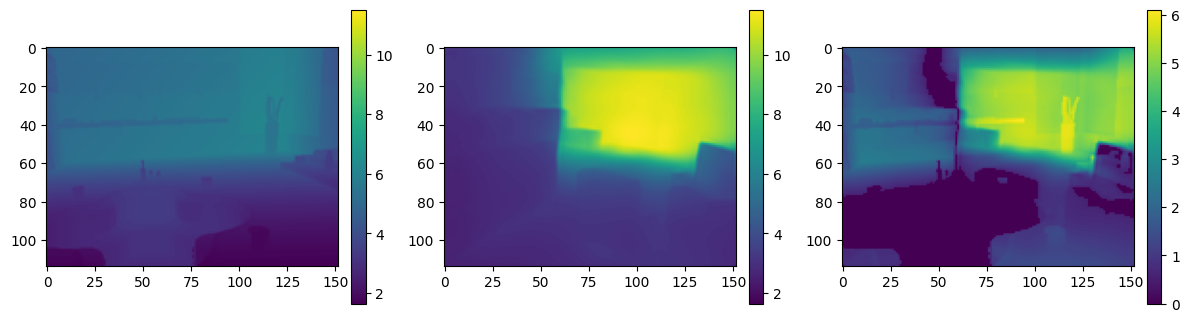

3
Depth max:  tensor(6.8857)
Depth min:  tensor(2.2257)
Depth groundtruth max:  tensor(6.2561)
Depth groundtruth min:  tensor(1.6435)
Error max:  tensor(5.0937)
Error min:  tensor(0.)


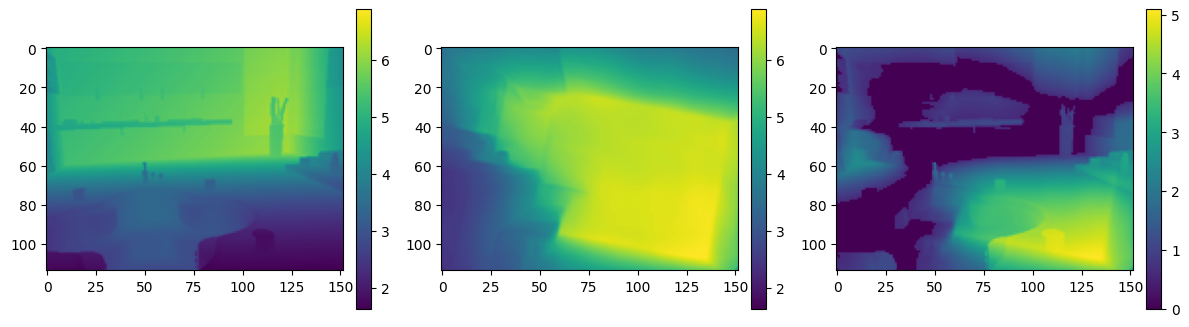

In [8]:
sample_batched = next(iter(test_loader))
for i in range(depth_outputs.shape[0]):
    curr_depth = depth_outputs[i,0,:,:,:].cpu()
    print(i)
    display_image_triplets(sample_batched["depth"][0,:].detach(), curr_depth.detach())
    